In [2]:
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision
    
try: 
    import torchbearer
except:
    !pip install torchbearer


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 kB 1.9 MB/s eta 0:00:00


In [3]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from torch import nn

In [4]:
class MyDataset(Dataset):
    def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("{} index out of range".format(self.__class__.__name__))

        rng_state = torch.get_rng_state()
        torch.manual_seed(index + self.random_offset)

        while True:
            img = torch.zeros(self.dim, self.dim)
            dx = torch.randint(-10,10,(1,),dtype=torch.float)
            dy = torch.randint(-10,10,(1,),dtype=torch.float)
            c = torch.randint(-20,20,(1,), dtype=torch.float)

            params = torch.cat((dy/dx, c))
            xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
            xy[:,1] = xy[:,0] * params[0] + params[1]

            xy.round_()
            xy = xy[ xy[:,1] > 0 ]
            xy = xy[ xy[:,1] < self.dim ]
            xy = xy[ xy[:,0] < self.dim ]

            for i in range(xy.shape[0]):
                x, y = xy[i][0], self.dim - xy[i][1]
                img[int(y), int(x)]=1
            if img.sum() > 2:
                break

        torch.set_rng_state(rng_state)
        return img.unsqueeze(0), params

    def __len__(self):
        return self.size


train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3,3), stride = 1, padding=1)
        self.fc1 = nn.Linear(48 *40*40, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [5]:
import torchbearer
from torch.utils.data import DataLoader
from torchbearer import Trial


transform = transforms.Compose([
    transforms.ToTensor()  # convert to tensor
])


trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)
valloader = DataLoader(val_data, batch_size=128, shuffle=True)

In [15]:

from torchbearer import callbacks

train_loss = torch.empty(100)
val_loss = torch.empty(100)
test_loss = torch.empty(100)

@callbacks.on_end_epoch
def my_callback(state):
  train_loss[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['loss']
  val_loss[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['val_loss']

In [16]:
model = SimpleCNN()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters())

trial = Trial(model, optimiser, loss_function, metrics=['loss', 'acc'], callbacks=[my_callback]).to(device)
trial.with_generators(trainloader, val_generator=valloader, test_generator=testloader)
trial.run(epochs=100)
# results = trial.evaluate(data_key=torchbearer.TEST_DATA)
# print(results)

0/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

0/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

1/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

1/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

2/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

2/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

3/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

3/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

4/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

4/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

5/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

5/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

6/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

6/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

7/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

7/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

8/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

8/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

9/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

9/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

10/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

10/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

11/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

11/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

12/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

12/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

13/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

13/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

14/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

14/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

15/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

15/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

16/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

16/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

17/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

17/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

18/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

18/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

19/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

19/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

20/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

20/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

21/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

21/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

22/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

22/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

23/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

23/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

24/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

24/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

25/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

25/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

26/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

26/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

27/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

27/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

28/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

28/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

29/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

29/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

30/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

30/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

31/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

31/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

32/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

32/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

33/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

33/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

34/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

34/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

35/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

35/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

36/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

36/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

37/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

37/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

38/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

38/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

39/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

39/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

40/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

40/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

41/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

41/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

42/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

42/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

43/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

43/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

44/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

44/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

45/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

45/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

46/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

46/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

47/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

47/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

48/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

48/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

49/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

49/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

50/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

50/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

51/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

51/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

52/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

52/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

53/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

53/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

54/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

54/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

55/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

55/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

56/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

56/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

57/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

57/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

58/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

58/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

59/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

59/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

60/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

60/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

61/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

61/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

62/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

62/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

63/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

63/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

64/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

64/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

65/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

65/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

66/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

66/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

67/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

67/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

68/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

68/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

69/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

69/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

70/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

70/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

71/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

71/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

72/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

72/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

73/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

73/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

74/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

74/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

75/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

75/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

76/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

76/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

77/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

77/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

78/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

78/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

79/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

79/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

80/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

80/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

81/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

81/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

82/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

82/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

83/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

83/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

84/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

84/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

85/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

85/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

86/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

86/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

87/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

87/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

88/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

88/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

89/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

89/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

90/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

90/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

91/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

91/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

92/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

92/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

93/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

93/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

94/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

94/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

95/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

95/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

96/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

96/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

97/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

97/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

98/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

98/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

99/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

99/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

[{'running_loss': 69.0391845703125,
  'running_mse': 69.0391845703125,
  'loss': 68.13314056396484,
  'mse': 68.16862487792969,
  'val_loss': 57.01340866088867,
  'val_mse': 57.06901168823242,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 61.28582000732422,
  'running_mse': 61.28582000732422,
  'loss': 61.48035430908203,
  'mse': 60.70329666137695,
  'val_loss': 55.08915710449219,
  'val_mse': 55.01026916503906,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 59.0894889831543,
  'running_mse': 59.0894889831543,
  'loss': 56.74604415893555,
  'mse': 55.95556640625,
  'val_loss': 45.970176696777344,
  'val_mse': 45.93888473510742,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 49.50330352783203,
  'running_mse': 49.50330352783203,
  'loss': 44.24936294555664,
  'mse': 44.382938385009766,
  'val_loss': 35.511478424072266,
  'val_mse': 35.387962341308594,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 34.87442398071289

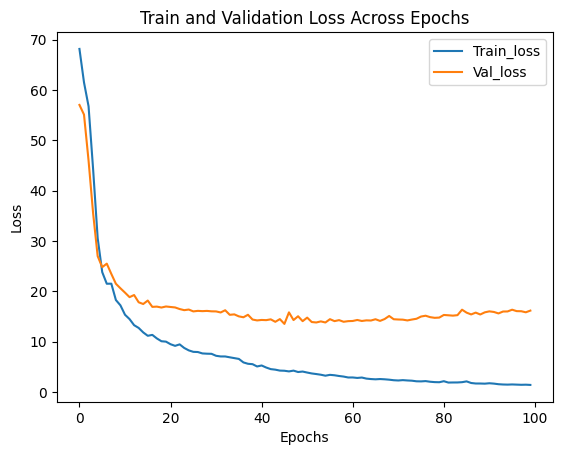

In [18]:
plt.plot([i for i in range(100)], train_loss, label = 'Train_loss')
plt.plot([i for i in range(100)], val_loss, label = 'Val_loss')
plt.title('Train and Validation Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('simplecnn1.png')
plt.show()

In [8]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# model = SimpleCNN().to(device)

# loss_function = nn.MSELoss()
# optimiser = torch.optim.Adam(model.parameters())

# train_loss = torch.empty(100)
# train_acc = torch.empty(100)

# test_loss = torch.empty(100)
# test_acc = torch.empty(100)

# # the epoch loop
# for epoch in range(100):
#     train_loss_val = 0.0
#     accuracy_train = 0.0
#     for data in trainloader:
#         model.train()
#         # get the inputs
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimiser.zero_grad()

#         outputs = model(inputs)
#         loss = loss_function(outputs, labels)
#         loss.backward()
#         optimiser.step()

#         train_loss_val += loss.item()
        
#     train_loss_val /= len(trainloader)

#     train_loss[epoch] = train_loss_val

    
#     model.eval()
#     with torch.no_grad():
#         test_loss_val = 0.0
#         for data in testloader:
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)

#             outputs = model(inputs)        
#             loss = loss_function(outputs, labels)

#             test_loss_val += loss.item()

#         test_loss_val = test_loss_val /  len(testloader)

#         test_loss[epoch] = test_loss_val

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3,3), stride = 1, padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3,3), stride = 1, padding = 1)
        self.max = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.max(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [8]:
from torchbearer import callbacks

train_loss_2 = torch.empty(100)
val_loss_2 = torch.empty(100)

@callbacks.on_end_epoch
def my_callback(state):
  train_loss_2[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['loss']
  val_loss_2[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['val_loss']

In [9]:
model = SimpleCNN()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters())

trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], callbacks=[my_callback]).to(device)
trial.with_generators(trainloader, val_generator = valloader, test_generator=testloader)
trial.run(epochs=100)
# results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)

0/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

0/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

1/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

1/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

2/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

2/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

3/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

3/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

4/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

4/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

5/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

5/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

6/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

6/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

7/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

7/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

8/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

8/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

9/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

9/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

10/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

10/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

11/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

11/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

12/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

12/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

13/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

13/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

14/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

14/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

15/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

15/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

16/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

16/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

17/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

17/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

18/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

18/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

19/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

19/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

20/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

20/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

21/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

21/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

22/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

22/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

23/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

23/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

24/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

24/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

25/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

25/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

26/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

26/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

27/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

27/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

28/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

28/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

29/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

29/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

30/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

30/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

31/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

31/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

32/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

32/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

33/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

33/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

34/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

34/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

35/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

35/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

36/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

36/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

37/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

37/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

38/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

38/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

39/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

39/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

40/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

40/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

41/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

41/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

42/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

42/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

43/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

43/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

44/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

44/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

45/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

45/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

46/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

46/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

47/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

47/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

48/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

48/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

49/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

49/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

50/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

50/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

51/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

51/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

52/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

52/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

53/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

53/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

54/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

54/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

55/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

55/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

56/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

56/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

57/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

57/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

58/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

58/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

59/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

59/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

60/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

60/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

61/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

61/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

62/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

62/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

63/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

63/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

64/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

64/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

65/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

65/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

66/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

66/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

67/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

67/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

68/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

68/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

69/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

69/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

70/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

70/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

71/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

71/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

72/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

72/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

73/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

73/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

74/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

74/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

75/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

75/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

76/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

76/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

77/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

77/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

78/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

78/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

79/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

79/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

80/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

80/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

81/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

81/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

82/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

82/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

83/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

83/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

84/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

84/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

85/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

85/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

86/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

86/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

87/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

87/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

88/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

88/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

89/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

89/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

90/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

90/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

91/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

91/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

92/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

92/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

93/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

93/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

94/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

94/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

95/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

95/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

96/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

96/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

97/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

97/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

98/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

98/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

99/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

99/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

0/1(e):   0%|          | 0/4 [00:00<?, ?it/s]

KeyError: ignored

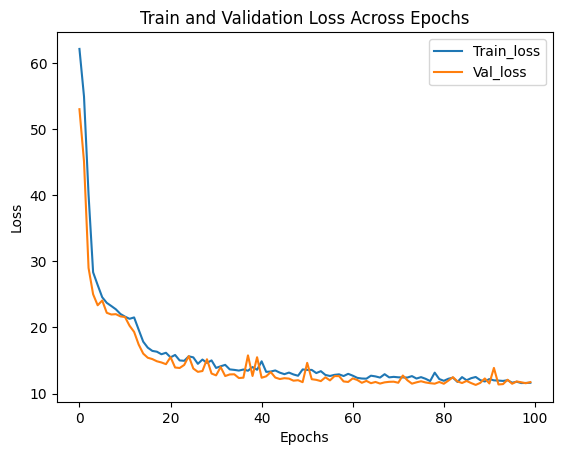

In [11]:
plt.plot([i for i in range(100)], train_loss_2, label = 'Train_loss')
plt.plot([i for i in range(100)], val_loss_2, label = 'Val_loss')
plt.title('Train and Validation Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('simplecnn2.png')
plt.show()

In [6]:
class SimpleCNN2(nn.Module):
    def __init__(self):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, (3,3), stride = 1, padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3,3), stride = 1, padding = 1)
        self.max = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        idxx = torch.repeat_interleave(torch.arange(-20,20, dtype=torch.float).unsqueeze(0) / 40.0, 
                                       repeats=40, dim=0).to(x.device)
        idxy = idxx.clone().t()
        idx = torch.stack([idxx, idxy]).unsqueeze(0)
        idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0) 
        x = torch.cat([x, idx], dim=1)
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.max(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [7]:

from torchbearer import callbacks

train_loss_3 = torch.empty(100)
val_loss_3 = torch.empty(100)

@callbacks.on_end_epoch
def my_callback(state):
  train_loss_3[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['loss']
  val_loss_3[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['val_loss']

In [8]:
model = SimpleCNN2()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters())

trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], callbacks=[my_callback]).to(device)
trial.with_generators(trainloader, val_generator = valloader, test_generator=testloader)
trial.run(epochs=100)
# results = trial.evaluate(data_key=torchbearer.TEST_DATA)
# print(results)

0/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

0/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

1/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

1/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

2/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

2/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

3/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

3/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

4/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

4/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

5/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

5/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

6/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

6/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

7/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

7/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

8/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

8/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

9/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

9/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

10/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

10/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

11/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

11/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

12/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

12/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

13/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

13/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

14/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

14/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

15/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

15/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

16/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

16/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

17/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

17/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

18/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

18/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

19/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

19/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

20/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

20/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

21/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

21/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

22/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

22/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

23/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

23/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

24/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

24/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

25/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

25/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

26/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

26/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

27/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

27/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

28/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

28/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

29/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

29/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

30/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

30/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

31/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

31/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

32/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

32/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

33/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

33/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

34/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

34/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

35/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

35/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

36/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

36/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

37/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

37/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

38/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

38/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

39/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

39/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

40/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

40/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

41/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

41/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

42/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

42/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

43/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

43/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

44/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

44/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

45/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

45/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

46/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

46/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

47/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

47/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

48/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

48/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

49/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

49/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

50/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

50/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

51/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

51/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

52/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

52/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

53/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

53/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

54/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

54/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

55/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

55/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

56/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

56/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

57/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

57/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

58/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

58/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

59/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

59/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

60/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

60/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

61/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

61/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

62/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

62/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

63/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

63/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

64/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

64/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

65/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

65/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

66/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

66/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

67/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

67/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

68/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

68/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

69/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

69/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

70/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

70/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

71/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

71/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

72/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

72/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

73/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

73/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

74/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

74/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

75/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

75/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

76/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

76/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

77/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

77/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

78/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

78/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

79/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

79/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

80/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

80/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

81/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

81/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

82/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

82/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

83/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

83/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

84/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

84/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

85/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

85/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

86/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

86/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

87/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

87/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

88/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

88/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

89/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

89/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

90/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

90/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

91/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

91/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

92/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

92/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

93/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

93/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

94/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

94/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

95/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

95/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

96/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

96/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

97/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

97/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

98/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

98/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

99/100(t):   0%|          | 0/40 [00:00<?, ?it/s]

99/100(v):   0%|          | 0/4 [00:00<?, ?it/s]

[{'running_loss': 64.63118743896484,
  'running_mse': 64.63118743896484,
  'loss': 63.27985763549805,
  'mse': 63.7724723815918,
  'val_loss': 54.706390380859375,
  'val_mse': 54.66023635864258,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 56.58095169067383,
  'running_mse': 56.58095169067383,
  'loss': 50.428890228271484,
  'mse': 50.91257858276367,
  'val_loss': 32.139198303222656,
  'val_mse': 32.01619338989258,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 31.009700775146484,
  'running_mse': 31.009700775146484,
  'loss': 21.79998016357422,
  'mse': 21.894174575805664,
  'val_loss': 14.401354789733887,
  'val_mse': 14.448166847229004,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 15.074105262756348,
  'running_mse': 15.074105262756348,
  'loss': 13.293150901794434,
  'mse': 13.485777854919434,
  'val_loss': 10.706232070922852,
  'val_mse': 10.699281692504883,
  'train_steps': 40,
  'validation_steps': 4},
 {'running_loss': 1

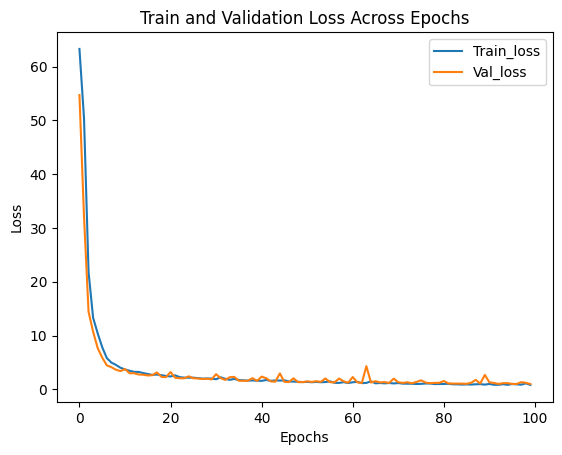

In [9]:
plt.plot([i for i in range(100)], train_loss_3, label = 'Train_loss')
plt.plot([i for i in range(100)], val_loss_3, label = 'Val_loss')
plt.title('Train and Validation Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('simplecnn3.png')
plt.show()